<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

In [58]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

Load data and set global variables

In [92]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

close = np.array(df['% Silica Concentrate'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

Positional Encoder

In [135]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=len(df)):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]        

Transformer Model

In [136]:
class TransAm(nn.Module):
    def __init__(self, feature_size=1, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

Window function, split data into sequence window

In [64]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

Split data in training and testing, prepared in windowed sequences and pass through GPU

In [137]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

Split into training batches

In [138]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

Training function

In [139]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

Evaluation function for model after training

In [140]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

Function to forecast 1 time step from window sequence

In [141]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

Function to forecast entire sequence

In [142]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

Prepare data for training model

In [93]:
train_data, val_data = get_data(logreturn , 0.7) # 60% train, 40% test split
model = TransAm().to(device)

Model parameters

In [72]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  3 # Number of epochs

Training loop

In [143]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step() 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |     3/   15 batches | lr 0.0000349169 | 541.79 ms | loss 7.2284307
| epoch   1 |     6/   15 batches | lr 0.0000349169 | 406.04 ms | loss 6.9170432
| epoch   1 |     9/   15 batches | lr 0.0000349169 | 402.40 ms | loss 5.9499750
| epoch   1 |    12/   15 batches | lr 0.0000349169 | 402.02 ms | loss 2.8564922
| epoch   1 |    15/   15 batches | lr 0.0000349169 | 361.75 ms | loss 4.1098481
--------------------------------------------------------------------------------
| end of epoch   1 | time:  6.34s
--------------------------------------------------------------------------------
| epoch   2 |     3/   15 batches | lr 0.0000331710 | 535.16 ms | loss 7.2105540
| epoch   2 |     6/   15 batches | lr 0.0000331710 | 397.45 ms | loss 6.9830073
| epoch   2 |     9/   15 batches | lr 0.0000331710 | 393.74 ms | loss 5.9673417
| epoch   2 |    12/   15 batches | lr 0.0000331710 | 402.21 ms | loss 2.8433327
| epoch   2 |    15/   15 batches | lr 0.0000331710 | 368.22 ms | loss 4.08

In [103]:
series = df["% Silica Concentrate"]
new_series = np.diff(np.log(series)) 
# getting only the value of zeroth index since the diff() operation looses first value.
new_series[0] = np.log(series.iloc[0])
result = np.exp(new_series.cumsum())

In [149]:
test_result, truth = forecast_seq(model, val_data)

2.3318326473236084 sec


In [ ]:
test_result.numpy()[0] = np.log(series.iloc[0])
test_result = np.exp(test_result.numpy().cumsum())

In [ ]:
truth.numpy()[0] = np.log(series.iloc[0])
truth_result = np.exp(truth.numpy().cumsum())

In [127]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

In [150]:
mape, mae, rmse = forecast_accuracy(truth.numpy(), test_result.numpy())
mape, mae, rmse

(1.311877, 0.49983272, 0.6311732594894748)

Plot forecasted sequence vs actual

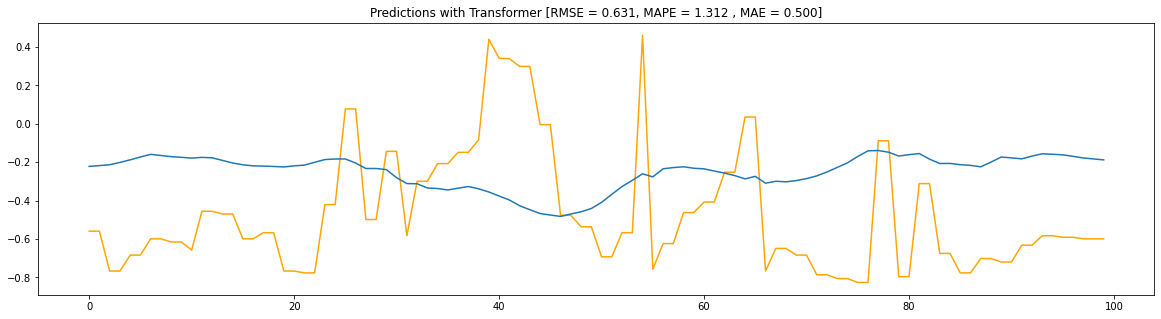

In [152]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(truth[0:100], color='orange')
plt.plot(test_result[0:100])
plt.title("Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

Test random sequence

Save model

In [80]:
torch.save(model.state_dict(), "transformer_ts.pth")

Load model

In [81]:
model2 = TransAm() # rename as model2
model2.load_state_dict(torch.load("transformer_ts.pth"))
model2.to(device)

TransAm(
  (pos_encoder): PositionalEncoding()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
    )
    (linear1): Linear(in_features=250, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=250, bias=True)
    (norm1): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=250, out_features=250, bias=True)
        )
        (linear1): Linear(in_features=250, out_features=2048, bias=True)
        (dropout): Dropout

Testing model on Boeing stock from the same time period

## Conclusion
Transformer model is able to train on a longer sequence compared to LSTM models (5 vs 10)  
Transformer model also trained faster, given the longer sequence length, and took lesser epochs to train the model

### Data Transforming and Normalising
Advantages of using cumulative sum of log returns compared to min-max scaler in normalising stocks prices,  
create better standardisation across stocks  
Training data augmentation allowed model to be trained on wider data points, resulting in the model generalising well across unseen data from test 2 and test 3  
Previous testing without data augmentation had models underperforming with higher loss